# Object Removal and Impainting Project
Participants:

- 
- 
- Alexei Ivanov (20917576)

## Description



# Setup
Run the following cells to setup your environment

In [1]:
# install dependencies
!pip install -r requirements.txt

In [2]:
import torch
import scipy
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from PIL import Image
from copy import deepcopy
import random
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np

/home/alex/miniconda3/envs/school/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/alex/miniconda3/envs/school/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/alex/miniconda3/envs/school/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, an

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# randomness for reproducability
seed = 484
random.seed(seed)
torch.manual_seed(seed)
#torch.use_deterministic_algorithms(True)

# Dataset
To train the model we decided to use OpenAI's Country211 Dataset. You can read more about the dataset here [https://github.com/openai/CLIP/blob/main/data/country211.md](https://github.com/openai/CLIP/blob/main/data/country211.md).

The following cell will download the dataset which is around 20GB

## Download and Create Dataset
We download the country211 dataset using pytorch, but since our objective is slightly different we need to create our own custom dataset and reload the data. We call ou custom dataset the country212 dataset.

In [5]:
# download data
train_dataset = torchvision.datasets.Country211("country211/", split="train", download=True)
val_dataset = torchvision.datasets.Country211("country211/", split="valid", download=True)
test_dataset = torchvision.datasets.Country211("country211/", split="test", download=True)

In [6]:
train_dataset

Dataset Country211
    Number of datapoints: 31650
    Root location: country211

In [7]:
val_dataset

Dataset Country211
    Number of datapoints: 10550
    Root location: country211

In [8]:
test_dataset

Dataset Country211
    Number of datapoints: 21100
    Root location: country211

In [9]:
# script to copy data into desired location and format
import os
import shutil

if not os.path.exists("country212"): os.mkdir("country212")
if not os.path.exists("country212/train"): os.mkdir("country212/train")
if not os.path.exists("country212/valid"): os.mkdir("country212/valid")
if not os.path.exists("country212/test"): os.mkdir("country212/test")

def flatten_dir(mode="train"):
    for dir in os.listdir(f"country211/country211/{mode}"):
        for file in os.listdir(f"country211/country211/{mode}/{dir}"):
            shutil.copy(f"country211/country211/{mode}/{dir}/{file}", f"country212/{mode}")

# flatten_dir("train")
# flatten_dir("valid")
# flatten_dir("test")

In [10]:
# assert script worker and all data is present
assert len(os.listdir("country212/train")) == len(train_dataset)
assert len(os.listdir("country212/valid/")) == len(val_dataset)
assert len(os.listdir("country212/test/")) == len(test_dataset)

In [11]:
STDS = torch.tensor([0.229, 0.224, 0.225])
MEANS = torch.tensor([0.485, 0.456, 0.406])

STDS = torch.tensor([0.5, 0.5, 0.5])
MEANS = torch.tensor([0.5, 0.5, 0.5])

In [12]:
class country212Dataset(Dataset):

    def __init__(self, root_dir, transforms=None) -> None:
        super().__init__()
        self.root_dir = root_dir
        self.transforms = transforms
        self.all_imgs = sorted(os.listdir(root_dir))
        

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, index):
        """
        This method is supposed to return training_img, correct_img. To generate this we do the following
        
            1) load the image
            2) apply given transforms to the image
            3) create a deep copy of the image which is going to be used as the ground truth image
            4) crop the center (CENTER_CROP_OUT_SIZE, CENTER_CROP_OUT_SIZE)
        """
        # (1) load image
        img_path = os.path.join(self.root_dir, self.all_imgs[index])
        image = Image.open(img_path).convert("RGB")

        # (2) apply given transforms to the image
        transformed_img = self.transforms(image) if self.transforms else image

        # (3) create deep copy of image
        ground_truth_image = deepcopy(transformed_img)

        # (4) crop the center
        #       an assumption here is that the image is 256x256 which is true because we constructed the transforms
        transformed_img[:, 103:153, 103:153] = (-MEANS / STDS)[:, None, None]

        return transformed_img, ground_truth_image

In [13]:

transforms = v2.Compose([
    v2.ToTensor(),
    v2.RandomResizedCrop(size=(256, 256), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    # v2.ToDtype(torch.float32),
    # v2.Normalize(mean=MEANS, std=STDS),
])

my_train_dataset = country212Dataset("country212/train/", transforms=transforms)
my_val_dataset = country212Dataset("country212/valid/", transforms=transforms)
my_test_dataset = country212Dataset("country212/test", transforms=transforms)

/home/alex/miniconda3/envs/school/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [14]:
assert len(my_train_dataset) == len(train_dataset)
assert len(my_val_dataset) == len(val_dataset)
assert len(my_test_dataset) == len(test_dataset)

## Explore Dataset

In [15]:
item = my_test_dataset[2]
print(item[0].shape, item[1].shape)

torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


In [16]:
item[0]

tensor([[[0.3295, 0.3225, 0.3233,  ..., 0.1961, 0.2000, 0.2028],
         [0.3264, 0.3230, 0.3259,  ..., 0.1991, 0.1999, 0.2007],
         [0.3265, 0.3233, 0.3289,  ..., 0.2003, 0.2008, 0.2013],
         ...,
         [0.0679, 0.0552, 0.0687,  ..., 0.1513, 0.1747, 0.1986],
         [0.0639, 0.0776, 0.0688,  ..., 0.1620, 0.1182, 0.1275],
         [0.0978, 0.0938, 0.0701,  ..., 0.1311, 0.1439, 0.1445]],

        [[0.4025, 0.4088, 0.4036,  ..., 0.2348, 0.2392, 0.2420],
         [0.4037, 0.4100, 0.4062,  ..., 0.2377, 0.2392, 0.2399],
         [0.4064, 0.4107, 0.4092,  ..., 0.2389, 0.2400, 0.2405],
         ...,
         [0.1008, 0.1010, 0.1129,  ..., 0.2332, 0.2583, 0.2849],
         [0.1006, 0.1262, 0.1170,  ..., 0.2411, 0.1973, 0.2037],
         [0.1394, 0.1433, 0.1202,  ..., 0.2046, 0.2136, 0.2104]],

        [[0.4520, 0.4435, 0.4389,  ..., 0.2390, 0.2431, 0.2460],
         [0.4467, 0.4436, 0.4415,  ..., 0.2419, 0.2431, 0.2438],
         [0.4480, 0.4441, 0.4445,  ..., 0.2431, 0.2439, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


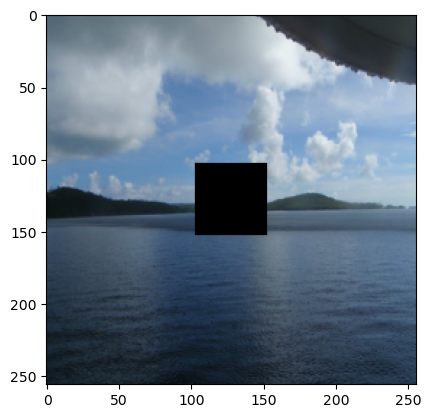

In [17]:
# train image 
plt.figure()
# unnormalized = item[0] * STDS[:, None, None] + MEANS[:, None, None]
plt.imshow(np.transpose(item[0], (1, 2, 0)))

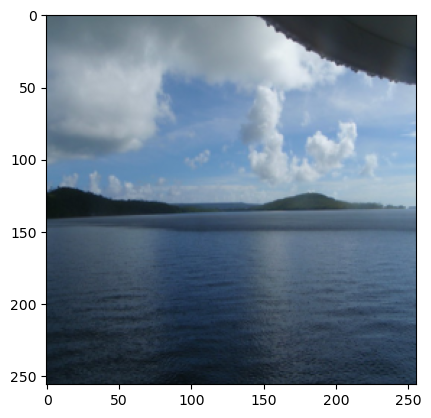

In [18]:
# ground truth image
plt.figure()
# unnormalized = item[0] * STDS[:, None, None] + MEANS[:, None, None]
plt.imshow(np.transpose(item[1], (1, 2, 0)))

## Setup Dataloader

In [19]:
# from now on we use our implementation of the dataset
train_dataset, val_dataset, test_dataset = my_train_dataset, my_val_dataset, my_test_dataset

In [20]:
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model
The model we chose to go for was a conditional GAN. Instead of taking a vector of random noise the GAN generator will be conditioned on the cropped/masked image.

In [21]:
class Generator(nn.Module):
    """
    This is the generator object of the GAN. The generator takes in the masked(cropped) image and fills in the masked/cropped out portion.

    The architecture takes inspiration from U-net:

    Encoder:
        1) 3x256x256 -> 64x128x128
        2) 64x128x128 -> 128x64x64
        3) 128x64x64 -> 256x32x32
        4) 256x32x32 -> 512x16x16

    Decoder:
        1) 512x16x16 -> 256x32x32
        2) (256 + 256)x32x32 -> 128x64x64
        3) (128 + 128)x64x64 -> 64x128x128
        4) (64 + 64)x128x128 -> 64x256x256
        5) 64x256x256 -> 3x256x256
    """
    
    def __init__(self):
        super().__init__()

        # encoder layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

        # decoder layers
        self.convt1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.convt2 = nn.ConvTranspose2d(512, 128, kernel_size=2, stride=2)
        self.convt3 = nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2)
        self.convt4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.convt5 = nn.ConvTranspose2d(64, 3, kernel_size=1, stride=1)

        # non-learnable layers
        self.down_sample = nn.AvgPool2d(2)
        self.relu = torch.nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # encode
        x1 = self.relu(self.bn1(self.down_sample(self.conv1(x))))
        x2 = self.relu(self.bn2(self.down_sample(self.conv2(x1))))
        x3 = self.relu(self.bn3(self.down_sample(self.conv3(x2))))
        x4 = self.relu(self.bn4(self.down_sample(self.conv4(x3))))

        # decode
        x5 = self.convt1(x4)
        x6 = self.convt2(torch.concat([x5, x3], dim=1))
        x7 = self.convt3(torch.concat([x6, x2], dim=1))
        x8 = self.convt4(torch.concat([x7, x1], dim=1))
        x9 = self.convt5(x8)
        x10 = self.sigmoid(x9)

        return x10


In [22]:
model = Generator()

# Create a random input tensor with the specified shape (3x256x256)
input_tensor = torch.randn(1, 3, 256, 256)

# Forward pass to get the output tensor
output_tensor = model(input_tensor)
output_tensor.shape

torch.Size([1, 3, 256, 256])

In [23]:
class Discriminator(nn.Module):
    """
    This is the discriminator class. The discriminator takes in an image and its job is to classify whether the image is generated(fake) 
    or real (non-generated).

    The architecture of the network is the same as a simple CNN classifier

        1) 3x256x256 -> 64x128x128
        2) 64x128x128 -> 128x64x64
        3) 128x64x64 -> 256x32x32
        4) 256x32x32 -> 512x16x16
        5) 512x16x16 -> 512x1x1
        5) 512 -> 256
        6) 256 -> 10
        7) 10 -> 1
    """

    def __init__(self):
        super().__init__()

        # conv layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)

        # batch norm layers
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

        # linear layers
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 10)
        self.fc3 = nn.Linear(10, 1)

        # non-learnable layers
        self.relu = nn.ReLU()
        self.down_sample = nn.AvgPool2d(2)
        self.max_pool = nn.MaxPool2d(16)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.down_sample(self.conv1(x))))
        x = self.relu(self.bn2(self.down_sample(self.conv2(x))))
        x = self.relu(self.bn3(self.down_sample(self.conv3(x))))
        x = self.relu(self.bn4(self.down_sample(self.conv4(x))))

        x = self.max_pool(x)
        x = x.view(x.size(0), x.size(1))
        x = self.fc1(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        # return un-normalized logit, can sigmoid after if you want
        return x



In [24]:
model = Discriminator()

# Create a random input tensor with the specified shape (3x256x256)
input_tensor = torch.randn(1, 3, 256, 256)

# Forward pass to get the output tensor
output_tensor = model(input_tensor)
output_tensor.shape

torch.Size([1, 1])

In [25]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.



# Losses, Optimizers and Schedulers

In [26]:
generator_loss = nn.BCEWithLogitsLoss()
generator_reconstruction_loss = nn.L1Loss()
discriminator_loss = nn.BCEWithLogitsLoss()

In [27]:
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3, weight_decay=0.9)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-3, weight_decay=0.9)

In [28]:
generator_scheduler = torch.optim.lr_scheduler.ExponentialLR(generator_optimizer, gamma=0.9)
discriminator_scheduler = torch.optim.lr_scheduler.ExponentialLR(discriminator_optimizer, gamma=0.9)

# Training

In [29]:
num_epochs = 2

In [30]:
def train(generator, discriminator):

    writer = SummaryWriter()
    iteration = 0

    print("Beginning training")
    for epoch in range(num_epochs):
        print(f"Epoch: {epoch}")
        for i, data in enumerate(train_loader):
            
            x, y = data
            x, y = x.to(device), y.to(device)
            batch_size = x.size(0)
            
            # ------------------------------------------------------#
            # train Discriminator first
            discriminator.zero_grad()

            # all real batch
            true_labels = torch.ones(batch_size, device=device)
            
            # forward
            output = discriminator(y).view(-1)
            
            # loss
            err_real = discriminator_loss(output, true_labels)

            # backward
            err_real.backward()

            # all fake batch
            fake_label = torch.zeros(batch_size, device=device)

            # forward
            fake_generated = generator(x)
            output = discriminator(fake_generated.detach()).view(-1)

            # loss
            err_fake = discriminator_loss(output, fake_label)

            # log loss to tensorboard
            writer.add_scalar("Loss/train/discriminator", (err_fake + err_real) / 2, iteration)

            # backward
            err_fake.backward()

            # update discriminator
            discriminator_optimizer.step()
            # ---------------------------------------------------------#

            # ---------------------------------------------------------#
            # train generator
            generator.zero_grad()

            # labels now should be real so that we confuse discriminator that
            # generator is creating real images
            real_label = torch.ones(batch_size, device=device)
            output = discriminator(fake_generated).view(-1)

            # loss
            # err_generator = generator_loss(output, real_label) + generator_reconstruction_loss(fake_generated, y)
            err_generator = generator_loss(output, real_label)

            # log loss to tensorboard
            writer.add_scalar("Loss/train/generator", err_generator, iteration)

            # backward
            err_generator.backward()

            # update generator
            generator_optimizer.step()
            # ---------------------------------------------------------#

            iteration += 1
        
        with torch.no_grad():
            print(f"Epoch {epoch} finished calculating validation metrics")
            val_loss = 0
            for i, data in enumerate(val_loader):
                x, y = data
                x, y = x.to(device), y.to(device)
                batch_size = x.size(0)

                output = generator(x)
                fake_label = torch.zeros(batch_size, device=device)
                val_loss += generator_loss(discriminator(output).view(-1), fake_label) + generator_reconstruction_loss(output, y) 
            
            writer.add_scalar("Loss/val", val_loss, epoch)
        
        generator_scheduler.step()
        discriminator_scheduler.step()

    writer.flush()
    writer.close()
    return generator, discriminator


In [31]:
trained_generator, trained_discriminator = train(generator, discriminator)

Beginning training
Epoch: 0
Epoch 0 finished calculating validation metrics
Epoch: 1
Epoch 1 finished calculating validation metrics


# Explore Trained Model

In [32]:
item = my_test_dataset[0]
print(item[0].shape, item[1].shape)

torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


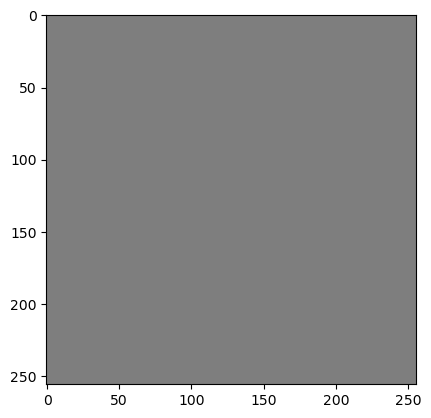

In [33]:
cropped_img = item[0][None].to(device)
with torch.no_grad():
    output = generator(cropped_img).detach().cpu()

plt.figure()
plt.imshow(np.transpose(output[0].numpy(), (1, 2, 0)))

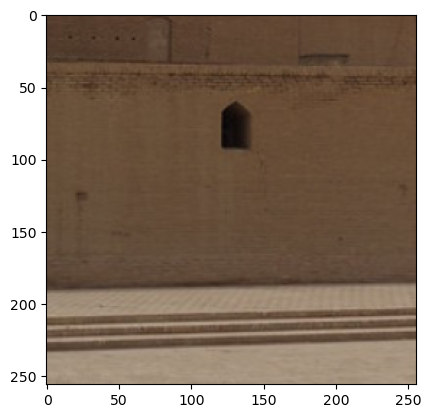

In [34]:
plt.figure()
plt.imshow(np.transpose(item[1].detach().cpu().numpy(), (1, 2, 0)))